In [ ]:
# default_exp inference
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device cpu


# 05e Integrating along the Flow Lines

A hypothetical advantage of creating flow-respecting embeddings with an associated vector field is that the vector field can be used to interpret the data in novel ways. One obvious application is integrating along the vector field to create flow lines. If FRED has done his job correctly, the flow lines should correspond to actual flows in the ambient space. In this notebook, we develop a function to do this flow-line integration, while returning points sampled from along the flow lines. These sampled points can be used for validation, e.g. by ensuring that their labels evolve forward in time.

In [ ]:
# export
def flow_integration_v1(X, V, starting_index, step_size, num_steps, min_step_size=0):
    """Returns a list of points along a flow line starting from `starting_index`.

    Parameters
    ----------
    X : torch tensor
        the embedded coordinates
    V : torch tensor
        the velocities associated with each coordinate
    starting_index : int
        the point to start the integration from
    step_size : real
        the maximum size of each step during the integration.
    num_steps : int
        number of steps to take, also number of points to return.
    """
    xi = X[starting_index]
    vi = V[starting_index]
    flow_indices = [starting_index]
    for stepnum in range(num_steps):
        # filter to just points within t*vi meters from xi (not including xi itself)
        distance_to_xi = torch.linalg.norm(X - xi, dim=1)
        # print(f"norm shape {distance_to_xi.shape}")
        filtered = ((distance_to_xi < torch.linalg.norm(vi*step_size)) & (distance_to_xi > torch.linalg.norm(vi*min_step_size)))
        # print(f"filtered shape {filtered.shape}")
        filtered_X  = X[filtered]
        assert len(filtered_X) > 0
        # change of coordinates to have xi at center
        filtered_X = filtered_X - xi
        # Get point which lies closest to the line projected by vi
        normalized_vis = torch.tile(vi/torch.linalg.norm(vi),(len(filtered_X),1))
        print("filtering ",torch.sum(filtered_X*normalized_vis,axis=1))
        filtered_forward = (torch.sum(filtered_X*normalized_vis,axis=1) > 0)
        filtered_X = filtered_X[filtered_forward]
        # print(torch.linalg.norm(filtered_X, axis=1)**2)
        normalized_vis = torch.tile(vi/torch.linalg.norm(vi),(len(filtered_X),1))
        closest_to_line = torch.argmin(torch.linalg.norm(filtered_X, axis=1)**2 - torch.sum(filtered_X*normalized_vis,axis=1))
        # reverse engineer index of closest_to_line in X
        idx = torch.arange(len(X))[filtered][filtered_forward][closest_to_line].detach().item()
        flow_indices.append(idx)
        # set new xi and vi
        xi = X[idx]
        vi = V[idx]
    return flow_indices

In [ ]:
# export
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
def flow_integration(X, V, starting_index, num_steps, step_size = "automatic", normalize_velocities = True):
    """Returns a list of points along a flow line starting from `starting_index`.

    Parameters
    ----------
    X : torch tensor
        the embedded coordinates
    V : torch tensor
        the velocities associated with each coordinate
    starting_index : int
        the point to start the integration from
    step_size : real
        the maximum size of each step during the integration.
    num_steps : int
        number of steps to take, also number of points to return.
    """
    if step_size == "automatic":
        # use the median distance to 10th nearest neighbor as proxy
        k = 10
        Dists = pairwise_distances(X)
        step_size = np.median(np.partition(Dists,k)[:,k])
        # print("using step size ",step_size)
    xi = X[starting_index]
    vi = V[starting_index]/torch.linalg.norm(V[starting_index])
    idx = starting_index
    flow_indices = [starting_index]
    for stepnum in range(num_steps):
        xj = xi + step_size*vi
        # print(f"step size is {torch.linalg.norm(step_size*vi)}. xj is {xj}. vi is {vi}. xi is {xi}")
        # filter out the base point
        X_filtered = torch.concat((X[:idx], X[idx+1:]), dim=0)
        # get new index and adjust
        new_idx = torch.argmin(torch.linalg.norm(X_filtered - xj, axis=1))
        if new_idx >= idx: new_idx += 1
        idx = new_idx
        # set new xi and vi
        flow_indices.append(idx)
        xi = X[idx]
        vi = V[idx]/torch.linalg.norm(V[idx])
    return flow_indices

In [ ]:
# export
def diffusion_flow_integration(X, V, starting_index, num_steps):
    # integrate along the manifold, but using the diffusion matrix rather than brute integration along flow arrows
    # preferred to the `flow_integrate` function if doing actual inference from FRED's output, as the diffusion driven integration process better mimics his loss function.
    pass

## Testing the integration
Starting with some toy datasets with known outcomes

##  Embedding the branch

Set sigma =  0.048603483


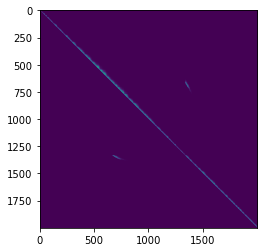

In [ ]:
from FRED.datasets import directed_sinh_branch
from FRED.data_processing import ManifoldWithVectorField
from torch.utils.data import DataLoader
X, flow, labels = directed_sinh_branch(num_nodes=2000)
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma="automatic", dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=10, flow_strength = 5)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma="automatic",
            flow_strength=20,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": 1,
            "kld": 0,
            "smoothness": 0,
            "flow neighbor loss": 1,
            "contrastive flow loss": 5,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = "Branch Embedding")

In [ ]:
FREDtrainer.fit(dataloader, n_epochs=50)

100%|██████████| 50/50 [03:28<00:00,  4.18s/it]


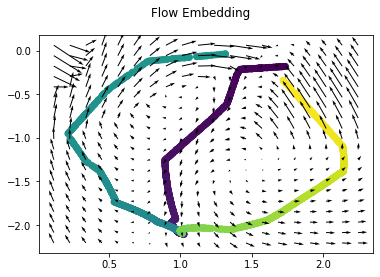

In [ ]:
FREDtrainer.visualize_embedding()

## Integrating along the branch

In [ ]:
Xembedded = FREDtrainer.embedded_points.detach()
Vembedded = FREDtrainer.embedded_velocities.detach()
flowline = flow_integration(Xembedded, Vembedded, starting_index = 200, step_size = "automatic", num_steps = 1000)

using step size  0.0153377205
step size is 0.015337719582021236. xj is tensor([ 1.1578, -0.8817]). vi is tensor([-0.2250, -0.9744]). xi is tensor([ 1.1612, -0.8667])
step size is 0.015337721444666386. xj is tensor([ 1.1470, -0.8974]). vi is tensor([-0.2112, -0.9774]). xi is tensor([ 1.1503, -0.8824])
step size is 0.015337720513343811. xj is tensor([ 1.1390, -0.9081]). vi is tensor([-0.2445, -0.9696]). xi is tensor([ 1.1427, -0.8932])
step size is 0.015337719582021236. xj is tensor([ 1.1300, -0.9199]). vi is tensor([-0.2825, -0.9593]). xi is tensor([ 1.1343, -0.9052])
step size is 0.015337720513343811. xj is tensor([ 1.1206, -0.9322]). vi is tensor([-0.3227, -0.9465]). xi is tensor([ 1.1256, -0.9177])
step size is 0.015337720513343811. xj is tensor([ 1.1114, -0.9444]). vi is tensor([-0.3633, -0.9317]). xi is tensor([ 1.1169, -0.9301])
step size is 0.015337720513343811. xj is tensor([ 1.1041, -0.9539]). vi is tensor([-0.3953, -0.9185]). xi is tensor([ 1.1102, -0.9398])
step size is 0.015

In [ ]:
# convert these into labels
lbs = np.zeros(len(Xembedded))
lbs[flowline] = 1 #+ np.arange(len(flowline))/len(flowline)

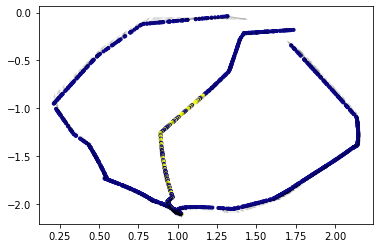

In [ ]:
from FRED.datasets import plot_directed_2d
plot_directed_2d(Xembedded.detach().numpy(),Vembedded.detach().numpy(),lbs, equal_aspect_ratio=False, cmap="plasma")

In [ ]:
flowline

[200,
 tensor(201),
 tensor(203),
 tensor(207),
 tensor(209),
 tensor(211),
 tensor(212),
 tensor(213),
 tensor(215),
 tensor(217),
 tensor(219),
 tensor(220),
 tensor(222),
 tensor(225),
 tensor(227),
 tensor(228),
 tensor(229),
 tensor(232),
 tensor(235),
 tensor(238),
 tensor(243),
 tensor(249),
 tensor(250),
 tensor(251),
 tensor(254),
 tensor(257),
 tensor(261),
 tensor(265),
 tensor(267),
 tensor(271),
 tensor(274),
 tensor(275),
 tensor(277),
 tensor(280),
 tensor(281),
 tensor(286),
 tensor(287),
 tensor(288),
 tensor(291),
 tensor(292),
 tensor(293),
 tensor(295),
 tensor(300),
 tensor(302),
 tensor(307),
 tensor(312),
 tensor(314),
 tensor(318),
 tensor(323),
 tensor(327),
 tensor(328),
 tensor(330),
 tensor(333),
 tensor(334),
 tensor(336),
 tensor(338),
 tensor(339),
 tensor(344),
 tensor(346),
 tensor(350),
 tensor(355),
 tensor(357),
 tensor(364),
 tensor(366),
 tensor(369),
 tensor(375),
 tensor(379),
 tensor(385),
 tensor(386),
 tensor(387),
 tensor(391),
 tensor(397),


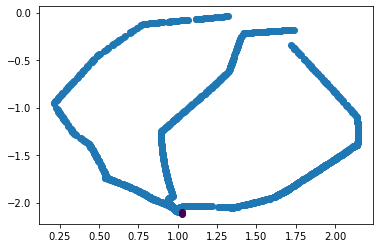

In [ ]:
pt = 658
coords = [ 1.0276, -2.1193]
plt.scatter(Xembedded[:,0],Xembedded[:,1])
plt.scatter(Xembedded[:,0][pt],Xembedded[:,1][pt],c=1)
plt.scatter(coords[0],coords[1],c=2)

In [ ]:
# export
from FRED.datasets import plot_directed_2d
def plot_flow_line(X,V,flowline):
    Xembedded = X.detach().numpy()
    Vembedded = V.detach().numpy()
    # convert these into labels
    lbs = np.ones(len(Xembedded))
    lbs[flowline] = 0 #+ np.arange(len(flowline))/len(flowline)
    plot_directed_2d(Xembedded,Vembedded,lbs, equal_aspect_ratio=False, cmap="plasma")